# Summarize Results
This notebook summarizes predictive modeling results for the Support Vector Machines (SVMs) and Convolutional Neural Networks (CNNs).

---

### Content:

- 1) Load Packages & Data
- 2) Calculate SVM Performance
- 3) Calculate CNN Performance
- 4) Calculate Human Performance
- 5) Summary of Results

---

# 1) Load Packages & Data

In [162]:
# load basic packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat  # this SciPy module loads mat-files
from IPython.display import Image
import matplotlib.image as mpimg

#plt.style.use('seaborn-whitegrid')  
sns.set_style('white')
pd.options.display.max_columns = 100

In [72]:
# load test data for X and y based on indices for stratified train/test split

data_path = '/Users/kacha/nf-ds/nf_capstone/data/'
skfold_path = '/Users/kacha/nf-ds/nf_capstone/data/skfold_1/'

X  = np.load(data_path + 'Xf.npy')
y_names = ['yT', 'yF', 'yS', 'yA', 'yE', 'yI']
X_test, y_test = {}, {}
X_train, y_train = {}, {}
X_mean = {}

for name in y_names:
    y = np.load(data_path + name + '.npy')
    
    test_idx = np.load(skfold_path + name + '_test_indices.npy')
    y_test[name] = y[test_idx]
    X_test[name] = X[test_idx]

    train_idx = np.load(skfold_path + name + '_train_raw_indices.npy')
    y_train[name] = y[train_idx]
    X_train[name] = X[train_idx]
    X_mean[name] = np.mean(X[train_idx], axis=0)
    
del X, y

In [73]:
# check dictionary keys/entries for test data

print(X_test.keys())
print(y_test.keys())
print(X_test['yT'].shape, y_test['yT'].shape, X_mean['yT'].shape)

dict_keys(['yT', 'yF', 'yS', 'yA', 'yE', 'yI'])
dict_keys(['yT', 'yF', 'yS', 'yA', 'yE', 'yI'])
(334, 224, 224, 3) (334,) (224, 224, 3)


---
# 2) Calculate SVM Performance

In [74]:
# load trained models and evaluate predictive model performance for test data

import pickle
import os
from sklearn.svm import SVR 
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

models_dir = '/Users/kacha/nf-ds/nf_capstone/models/final_models/'
svm_pred = {}
svm_pred_train = {}
svm_RMSE = {}
svm_MAE = {}
svm_PC = {}

for name in y_names:
    
    # find filenname matching y name
    filename = [file for file in os.listdir(models_dir) if file.endswith(name + '.sav')][0]

    # load svm model (sklearn pipeline with pca + svm) from .sav file
    print('loading model: ' + filename)
    model = pickle.load(open(models_dir + filename, 'rb'))
    
    # center and flatten X array
    X_test_c = X_test[name] - X_mean[name]
    X_test_cf = X_test_c.reshape((X_test_c.shape[0], -1))
    X_train_c = X_train[name] - X_mean[name]
    X_train_cf = X_train_c.reshape((X_train_c.shape[0], -1))

    # make prediction
    svm_pred[name] = model.predict(X_test_cf)
    svm_pred_train[name] = model.predict(X_train_cf)
    
    # calculate RMSE, MAE and PC
    svm_RMSE[name] = np.sqrt(mean_squared_error(y_test[name], svm_pred[name]))
    svm_MAE[name] = mean_absolute_error(y_test[name], svm_pred[name])
    svm_PC[name] = 100*pearsonr(y_test[name], svm_pred[name])[0]

loading model: s19_Xf_yT.sav
loading model: s23_Xf_yF.sav
loading model: s24_Xf_yS.sav
loading model: s25_Xf_yA.sav
loading model: s26_Xf_yE.sav
loading model: s27_Xf_yI.sav


In [75]:
# show model evaluation metrics as a dataframe

svm_eval = pd.DataFrame([svm_RMSE, svm_MAE, svm_PC], index=['svm_RMSE','svm_MAE','svm_PC']).T
svm_eval

,svm_RMSE,svm_MAE,svm_PC
yA,0.964670,0.798716,60.663567
yE,0.585711,0.470921,51.941459
yF,0.944699,0.728113,64.398990
yI,0.646571,0.505192,52.858617
yS,0.882552,0.670554,65.992757
yT,0.730125,0.583062,62.246889


In [23]:
# save model evaluation dataframe
svm_eval.to_csv(models_dir + 'svm_eval.csv', index_label='model')

In [90]:
# save true and predicted ratings for trust-svm-model

np.save(models_dir + 'svm_trust_test.npy', y_test['yT'])
np.save(models_dir + 'svm_trust_pred_test.npy', svm_pred['yT'])
np.save(models_dir + 'svm_trust_train.npy', y_train['yT'])
np.save(models_dir + 'svm_trust_pred_train.npy', svm_pred_train['yT'])

In [164]:
# load true and predicted ratings for trust-svm-model (if starting notebook from here)

models_dir = '/Users/kacha/nf-ds/nf_capstone/models/final_models/'
y_test['yT'] = np.load(models_dir + 'svm_trust_test.npy')
svm_pred['yT'] = np.load(models_dir + 'svm_trust_pred_test.npy')
y_train['yT'] = np.load(models_dir + 'svm_trust_train.npy')
svm_pred_train['yT'] = np.load(models_dir + 'svm_trust_pred_train.npy')

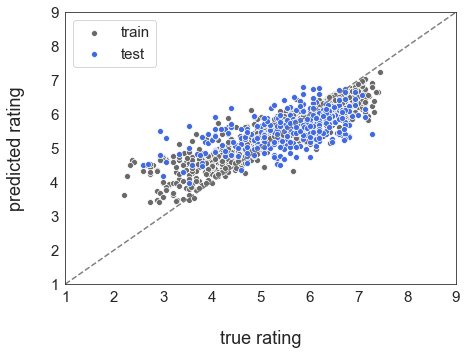

In [165]:
# make scatterplot for best trust-svm-model

# load train and test data for trust
name = 'yT'

fig, ax = plt.subplots(figsize=(7,5))
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(1.0)
sns.scatterplot(y_train[name], svm_pred_train[name], color='dimgray', label='train') # royalblue
sns.scatterplot(y_test[name], svm_pred[name], color='royalblue', label='test'); # crimson

plt.xlabel('\ntrue rating', size=18)
plt.ylabel('predicted rating\n', size=18);
plt.legend(['train','test'], fontsize=15)
lims = (1,9)
plt.ylim(lims)
plt.xlim(lims)
plt.xticks(size=15)
plt.yticks(size=15)
plt.plot(lims, lims, ls="--", c='gray');

---
# 3) Calculate CNN Performance

In [125]:
# load test data for X and y based on indices for stratified train/val/test split

data_path = '/Users/kacha/nf-ds/nf_capstone/data/'
skfold_path = '/Users/kacha/nf-ds/nf_capstone/data/skfold_1/'

X  = np.load(data_path + 'Xf.npy')
y_names = ['yT', 'yF', 'yS', 'yA', 'yE', 'yI']
X_test, y_test = {}, {}
X_train, y_train = {}, {}
X_val, y_val = {}, {}

for name in y_names[:1]:
    y = np.load(data_path + name + '.npy')
    
    test_idx = np.load(skfold_path + name + '_test_indices.npy')
    y_test[name] = y[test_idx]
    X_test[name] = X[test_idx]

    train_idx = np.load(skfold_path + name + '_train_indices.npy')
    y_train[name] = y[train_idx]
    X_train[name] = X[train_idx]
    
    val_idx = np.load(skfold_path + name + '_val_indices.npy')
    y_val[name] = y[val_idx]
    X_val[name] = X[val_idx]
    
del X, y

In [126]:
# preprocess_input function of vggface adapted from: 
# https://github.com/rcmalli/keras-vggface/blob/master/keras_vggface/utils.py

def preprocess_input_vggface(x):
    
    x_temp = x*255 # np.copy(x)
    x_temp = x_temp[..., ::-1]
    x_temp[..., 0] -= 91.4953
    x_temp[..., 1] -= 103.8827
    x_temp[..., 2] -= 131.0912

    return x_temp

In [ ]:
# load final trained CNN models

from tensorflow.keras.models import load_model

cnn_pred = {}
cnn_pred_train = {}
cnn_pred_val = {}
cnn_RMSE = {}
cnn_MAE = {}
cnn_PC = {}

for name in y_names[:1]:
    
    # find filenname matching y name
    filename = [file for file in os.listdir(models_dir) if file.endswith(name + '_Xf.h5')][0]

    # load cnn model
    print('loading model: ' + filename)
    model = load_model(models_dir + filename)
    
    # center and preprocess X array
    X_test_pp = preprocess_input_vggface(X_test[name])
    X_train_pp = preprocess_input_vggface(X_train[name])
    X_val_pp = preprocess_input_vggface(X_val[name])
    
    # make prediction
    cnn_pred[name] = model.predict(X_test_pp).ravel()
    cnn_pred_train[name] = model.predict(X_train_pp).ravel()
    cnn_pred_val[name] = model.predict(X_val_pp).ravel()
    
    # calculate RMSE, MAE and PC
    cnn_RMSE[name] = np.sqrt(mean_squared_error(y_test[name], cnn_pred[name]))
    cnn_MAE[name] = mean_absolute_error(y_test[name], cnn_pred[name])
    cnn_PC[name] = 100*pearsonr(y_test[name], cnn_pred[name])[0]

In [78]:
# show model evaluation metrics as a dataframe

cnn_eval = pd.DataFrame([cnn_RMSE, cnn_MAE, cnn_PC], index=['cnn_RMSE','cnn_MAE','cnn_PC']).T
cnn_eval

,cnn_RMSE,cnn_MAE,cnn_PC
yA,0.765249,0.617835,79.907769
yE,0.529032,0.419123,64.003407
yF,0.606260,0.470397,86.972002
yI,0.581789,0.465971,64.498250
yS,0.686854,0.541564,83.807503
yT,0.647345,0.537998,80.005322


In [20]:
# save model evaluation dataframe
cnn_eval.to_csv(models_dir + 'cnn_eval.csv', index_label='model')

In [129]:
# save true and predicted ratings for trust-cnn-model

np.save(models_dir + 'cnn_trust_test.npy', y_test['yT'])
np.save(models_dir + 'cnn_trust_pred_test.npy', cnn_pred['yT'])
np.save(models_dir + 'cnn_trust_train.npy', y_train['yT'])
np.save(models_dir + 'cnn_trust_pred_train.npy', cnn_pred_train['yT'])
np.save(models_dir + 'cnn_trust_val.npy', y_val['yT'])
np.save(models_dir + 'cnn_trust_pred_val.npy', cnn_pred_val['yT'])

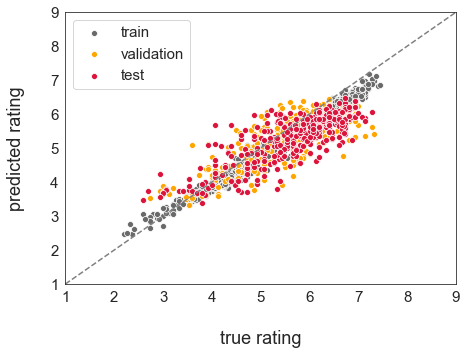

In [160]:
# make scatterplot for best trust-cnn-model (including validation set)

# load train and test data for trust
name = 'yT'

fig, ax = plt.subplots(figsize=(7,5))
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(1.0)
sns.scatterplot(y_train[name], cnn_pred_train[name], color='dimgray', label='train')
sns.scatterplot(y_val[name], cnn_pred_val[name], color='orange', label='validation')
sns.scatterplot(y_test[name], cnn_pred[name], color='crimson', label='test');  # crimson

plt.xlabel('\ntrue rating', size=18)
plt.ylabel('predicted rating\n', size=18);
plt.legend(['train','validation','test'], fontsize=15)
lims = (1,9)
plt.ylim(lims)
plt.xlim(lims)
plt.xticks(size=15)
plt.yticks(size=15)
plt.plot(lims, lims, ls="--", c='gray');

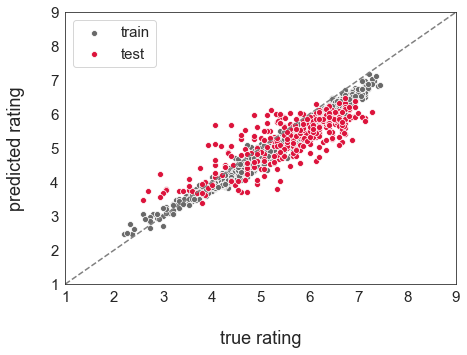

In [161]:
# make scatterplot for best trust-cnn-model (excluding validation set)

# load train and test data for trust
name = 'yT'

fig, ax = plt.subplots(figsize=(7,5))
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(1.0)
sns.scatterplot(y_train[name], cnn_pred_train[name], color='dimgray', label='train')
#sns.scatterplot(y_val[name], cnn_pred_val[name], color='orange', label='validation')
sns.scatterplot(y_test[name], cnn_pred[name], color='crimson', label='test');  # crimson

plt.xlabel('\ntrue rating', size=18)
plt.ylabel('predicted rating\n', size=18);
plt.legend(['train','test'], fontsize=15)
lims = (1,9)
plt.ylim(lims)
plt.xlim(lims)
plt.xticks(size=15)
plt.yticks(size=15)
plt.plot(lims, lims, ls="--", c='gray');

---
# 4) Calculate Human Performance

In [53]:
# Load data for single human ratings

psych_data_dir = '/Users/kacha/nf-ds/nf_capstone/10k_US_Data/Full Attribute Scores/psychology attributes/'
file_all = psych_data_dir + 'psychology_attributes_All.csv'
df_all = pd.read_csv(file_all)

# edit column names
col_replace_dict = {'egotistic':'egoistic',
                    'emotStable': 'stable',
                    'emotUnstable': 'unstable',
                    'Image #': 'imageID',
                    'Filename': 'filename'}
df_all.rename(columns=col_replace_dict, inplace=True)
df_all.head(3)

,filename,imageID,atypical,boring,calm,catch,catchAns,cold,common,confident,egoistic,unstable,forgettable,intelligent,introverted,kind,responsible,subID,subage,submale,subrace,trustworthy,unattractive,unemotional,unfamiliar,unfriendly,unhappy,weird,aggressive,attractive,caring,catch.1,catchAns.1,stable,emotional,familiar,friendly,happy,humble,interesting,irresponsible,mean,memorable,normal,sociable,subID.1,subage.1,submale.1,subrace.1,typical,uncertain,uncommon,unintelligent,untrustworthy
0,Google_1_Danielle Goble_5_oval.jpg,1,4.0,6.0,6.0,7.0,7.0,6.0,5.0,7.0,3.0,4.0,6.0,4.0,7.0,2.0,6.0,922.0,4.0,0.0,4.0,4.0,3.0,3.0,6.0,6.0,5.0,6.0,5.0,2.0,3.0,9.0,9,4.0,4.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,4.0,5.0,4.0,670,2.0,1.0,0.0,4.0,3.0,5.0,5.0,6.0
1,Google_1_Danielle Goble_5_oval.jpg,1,3.0,9.0,6.0,9.0,9.0,1.0,8.0,4.0,3.0,1.0,9.0,6.0,3.0,6.0,6.0,113.0,3.0,0.0,1.0,4.0,9.0,7.0,1.0,4.0,3.0,1.0,2.0,7.0,7.0,3.0,3,8.0,6.0,7.0,8.0,4.0,6.0,4.0,2.0,2.0,3.0,8.0,8.0,306,4.0,1.0,1.0,7.0,2.0,2.0,1.0,2.0
2,Google_1_Danielle Goble_5_oval.jpg,1,5.0,5.0,6.0,8.0,8.0,5.0,5.0,7.0,6.0,5.0,5.0,6.0,5.0,5.0,5.0,901.0,4.0,0.0,1.0,5.0,7.0,5.0,8.0,5.0,4.0,5.0,6.0,5.0,4.0,5.0,5,6.0,5.0,3.0,5.0,5.0,3.0,6.0,4.0,6.0,6.0,6.0,6.0,1274,3.0,0.0,2.0,5.0,4.0,7.0,4.0,4.0


In [56]:
# Load data for mean human ratings

file_mean = psych_data_dir + 'psychology_attributes_Mean.csv'
df_mean = pd.read_csv(file_mean)
df_mean.rename(columns=col_replace_dict, inplace=True)
df_mean.head(3)

,filename,imageID,atypical,boring,calm,catch,catchAns,cold,common,confident,egoistic,unstable,forgettable,intelligent,introverted,kind,responsible,subID,subage,submale,subrace,trustworthy,unattractive,unemotional,unfamiliar,unfriendly,unhappy,weird,aggressive,attractive,caring,catch.1,catchAns.1,stable,emotional,familiar,friendly,happy,humble,interesting,irresponsible,mean,memorable,normal,sociable,subID.1,subage.1,submale.1,subrace.1,typical,uncertain,uncommon,unintelligent,untrustworthy
0,Google_1_Danielle Goble_5_oval.jpg,1,3.93,6.00,6.29,5.93,5.93,4.13,5.53,5.67,3.67,3.20,4.93,5.60,5.13,5.00,5.80,NaN,3.0,0.0,2.0,5.33,4.40,4.47,4.07,4.60,3.73,3.93,4.80,4.87,4.67,5.87,5.93,5.80,3.67,4.00,4.33,3.80,4.73,4.13,3.53,4.53,4.40,5.93,4.67,NaN,4.00,0.00,1.0,5.40,4.27,4.67,3.33,3.67
1,Google_1_Phillip Owensby_9_oval.jpg,2,2.93,3.87,6.47,5.00,5.00,2.07,5.93,6.53,2.20,2.13,4.60,6.60,2.60,7.00,7.47,NaN,3.0,0.5,1.0,6.73,3.27,2.07,3.27,1.87,2.00,1.67,3.13,4.73,6.93,5.93,5.93,7.07,5.80,4.27,6.73,7.13,6.13,4.93,2.20,2.53,4.40,7.33,6.60,NaN,3.50,0.50,1.0,5.73,2.60,2.60,2.67,2.60
2,Google_1_Douglas Ziegler_3_oval.jpg,3,2.87,4.20,6.67,4.73,4.73,3.20,5.73,6.07,3.60,2.93,4.27,6.47,3.40,6.47,6.67,NaN,NaN,NaN,NaN,6.40,3.87,2.87,3.80,2.60,2.93,3.20,2.40,4.60,6.07,4.73,4.73,6.20,5.14,4.40,6.67,6.73,5.67,4.80,2.47,2.53,4.73,6.20,6.67,NaN,2.75,0.75,1.0,5.93,3.27,3.33,2.73,2.73


In [54]:
# remove ratings for first attribute list if catch != catchAns

# attribute list 1
df_all.iloc[:,2:28].columns
attribute_list_1 = ['atypical', 'boring', 'calm', 'cold', 'common','confident', 'egoistic', 'unstable',
                    'forgettable', 'intelligent', 'introverted', 'kind', 'responsible', 'trustworthy', 
                    'unattractive', 'unemotional', 'unfamiliar','unfriendly', 'unhappy', 'weird']

exclude_1 = df_all.catchAns != df_all.catch
print('Exclude number of raters for list 1:', exclude_1.sum())

exclude_1_idx = np.where(exclude_1)[0]
df_all.loc[exclude_1,attribute_list_1] = np.nan

Exclude number of raters for list 1: 279


In [55]:
# remove ratings for second attribute list if catch.1 != catchAns.1

# attribute list 2
df_all.iloc[:,28:].columns
attribute_list_2 = ['aggressive', 'attractive', 'caring', 'stable', 'emotional', 'familiar', 'friendly', 
                    'happy', 'humble', 'interesting', 'irresponsible', 'mean', 'memorable', 'normal',
                    'sociable', 'typical', 'uncertain', 'uncommon', 'unintelligent', 'untrustworthy']

exclude_2 = df_all['catchAns.1'] != df_all['catch.1']
print('Exclude number of raters for list 2:', exclude_2.sum())

exclude_2_idx = np.where(exclude_2)[0]
df_all.loc[exclude_2,attribute_list_2] = np.nan

Exclude number of raters for list 2: 295


In [57]:
# edit column names

replace_yname_dict = {'trustworthy': 'yT',
                      'friendly': 'yF',
                      'sociable': 'yS',
                      'attractive': 'yA',
                      'emotional': 'yE',
                      'intelligent': 'yI'}
df_all.rename(columns=replace_yname_dict, inplace=True)
df_mean.rename(columns=replace_yname_dict, inplace=True)
df_mean.head(3)

,filename,imageID,atypical,boring,calm,catch,catchAns,cold,common,confident,egoistic,unstable,forgettable,yI,introverted,kind,responsible,subID,subage,submale,subrace,yT,unattractive,unemotional,unfamiliar,unfriendly,unhappy,weird,aggressive,yA,caring,catch.1,catchAns.1,stable,yE,familiar,yF,happy,humble,interesting,irresponsible,mean,memorable,normal,yS,subID.1,subage.1,submale.1,subrace.1,typical,uncertain,uncommon,unintelligent,untrustworthy
0,Google_1_Danielle Goble_5_oval.jpg,1,3.93,6.00,6.29,5.93,5.93,4.13,5.53,5.67,3.67,3.20,4.93,5.60,5.13,5.00,5.80,NaN,3.0,0.0,2.0,5.33,4.40,4.47,4.07,4.60,3.73,3.93,4.80,4.87,4.67,5.87,5.93,5.80,3.67,4.00,4.33,3.80,4.73,4.13,3.53,4.53,4.40,5.93,4.67,NaN,4.00,0.00,1.0,5.40,4.27,4.67,3.33,3.67
1,Google_1_Phillip Owensby_9_oval.jpg,2,2.93,3.87,6.47,5.00,5.00,2.07,5.93,6.53,2.20,2.13,4.60,6.60,2.60,7.00,7.47,NaN,3.0,0.5,1.0,6.73,3.27,2.07,3.27,1.87,2.00,1.67,3.13,4.73,6.93,5.93,5.93,7.07,5.80,4.27,6.73,7.13,6.13,4.93,2.20,2.53,4.40,7.33,6.60,NaN,3.50,0.50,1.0,5.73,2.60,2.60,2.67,2.60
2,Google_1_Douglas Ziegler_3_oval.jpg,3,2.87,4.20,6.67,4.73,4.73,3.20,5.73,6.07,3.60,2.93,4.27,6.47,3.40,6.47,6.67,NaN,NaN,NaN,NaN,6.40,3.87,2.87,3.80,2.60,2.93,3.20,2.40,4.60,6.07,4.73,4.73,6.20,5.14,4.40,6.67,6.73,5.67,4.80,2.47,2.53,4.73,6.20,6.67,NaN,2.75,0.75,1.0,5.93,3.27,3.33,2.73,2.73


In [72]:
# get evaluation metrics for single human rater

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

human_RMSE = {}
human_MAE = {}
human_PC = {}

human_RMSE_loo = {}
human_MAE_loo = {}
human_PC_loo = {}

for name in y_names:
    
    selected_attribute = name

    # make dataframe for single-human ratings of trustworthiness (or another selected attribute)
    rating_single = df_all[['imageID',selected_attribute]].copy()
    rating_single['rater'] = rating_single.groupby('imageID').cumcount()+1
    rating_single = rating_single.pivot(index='imageID', columns='rater', values=selected_attribute)
    #rating_single.head(3)
    
    # make dataframe for mean human ratings of trustworthiness (or another selected attribute)
    rating_mean = df_mean[['imageID',selected_attribute]].copy()
    rating_mean.index = rating_mean.imageID
    rating_mean.drop('imageID',axis=1, inplace=True)
    #rating_mean.head()
    
    # join single-human and mean ratings in one dataframe
    df_ratings = rating_single.join(rating_mean, on='imageID')
    df_ratings.reset_index(inplace=True)
    
    # compute average correlation of two raters
    df_for_corr = df_ratings.iloc[:,1:16]
    corr_mat = df_for_corr.corr()  # corr() excludes NaN/null values
    mean_rater_corr = corr_mat.values[np.triu_indices_from(corr_mat,1)].mean() 
                                  # triu_indices_from returns idx for upper-triangle

        
    # OPTION 1: compute RMSE, MAE and PC - WITHOUT leave-one-out
    #============================================================
    # Note: Mean PC with leave-out-out (0.38) equals value reported by Grant et al. in Table 1.
        
    # calculate pearson correlations between single rater and mean rating (for each rater)        
    n_raters = 15 # (for rater 16 there are 2122 from 2222 image ratings missing)
    pc_all = np.zeros(n_raters)
    rmse_all = np.zeros(n_raters)
    mae_all = np.zeros(n_raters)

    for rater in range(1,n_raters+1):
        single = df_ratings.loc[:,rater].values
        NAs = np.isnan(single)
        average = df_ratings.loc[:,selected_attribute].values
    
        # pearson correlation
        pc = 100*pearsonr(single[~NAs], average[~NAs])[0]
        pc_all[rater-1] = pc
    
        # rmse
        rmse = np.sqrt(mean_squared_error(single[~NAs], average[~NAs]))
        rmse_all[rater-1] = rmse  
    
        # mae
        mae = mean_absolute_error(single[~NAs], average[~NAs])
        mae_all[rater-1] = mae 
    
    # summarize metrics for selected attribute in dictionary
    human_RMSE[name] = np.mean(rmse_all)
    human_MAE[name] = np.mean(mae_all)
    human_PC[name] = np.mean(pc_all)
    
    
    # OPTION 2: compute RMSE, MAE and PC - WITH leave-one-out
    #============================================================

    # calculate pearson correlations between single rater and mean rating (for each rater)
    n_raters = 15 # (for rater 16 there are 2122 from 2222 image ratings missing)
    pc_loo = np.zeros(n_raters)
    rmse_loo = np.zeros(n_raters)
    mae_loo = np.zeros(n_raters)

    for rater in range(1,n_raters+1):
        single = df_ratings.loc[:,rater].values
        NAs = np.isnan(single)  # or: df_ratings.loc[:,1].isna().values
        average = df_ratings.iloc[:,1:16].drop(rater,axis=1).mean(axis=1)  # leave-one-out average
    
        # pearson correlation
        pc = 100*pearsonr(single[~NAs], average[~NAs])[0]
        pc_loo[rater-1] = pc
    
        # rmse
        rmse = np.sqrt(mean_squared_error(single[~NAs], average[~NAs]))
        rmse_loo[rater-1] = rmse  
    
        # mae
        mae = mean_absolute_error(single[~NAs], average[~NAs])
        mae_loo[rater-1] = mae 
        
    # summarize metrics for selected attribute in dictionary
    human_RMSE_loo[name] = np.mean(rmse_loo)
    human_MAE_loo[name] = np.mean(mae_loo)
    human_PC_loo[name] = np.mean(pc_loo)

In [74]:
# show human evaluation metrics as a dataframe (with leave-one-out)

human_eval_loo = pd.DataFrame([human_RMSE_loo, human_MAE_loo, human_PC_loo], 
                               index=['human_RMSE_loo','human_MAE_loo','human_PC_loo']).T
human_eval_loo

,human_RMSE_loo,human_MAE_loo,human_PC_loo
yA,1.914350,1.535867,47.114912
yE,1.945803,1.575916,18.655444
yF,1.733427,1.363056,52.949597
yI,1.717671,1.347344,27.574830
yS,1.751543,1.381472,47.388709
yT,1.771638,1.407893,37.989456


In [73]:
# show human evaluation metrics as a dataframe (without leave-one-out)

human_eval = pd.DataFrame([human_RMSE, human_MAE, human_PC], index=['human_RMSE','human_MAE','human_PC']).T
human_eval

,human_RMSE,human_MAE,human_PC
yA,1.787004,1.433758,56.067916
yE,1.816196,1.471214,36.068006
yF,1.618116,1.272207,60.603626
yI,1.602251,1.256831,42.012176
yS,1.634906,1.289446,56.286643
yT,1.652594,1.313305,49.334354


In [75]:
# save human evaluation dataframes

human_eval.to_csv(models_dir + 'human_eval.csv', index_label='model')
human_eval_loo.to_csv(models_dir + 'human_eval_loo.csv', index_label='model')

---
# 5) Summary of Results

In [136]:
# join all dataframes (Human, SVM, CNN) and save joined dataframe

df_eval = pd.concat([human_eval, svm_eval, cnn_eval], axis=1)
df_eval = df_eval.reindex(y_names)
df_eval.rename({'yT': 'Trustworthy', 
                'yF': 'Friendly', 
                'yS': 'Sociable', 
                'yA': 'Attractive', 
                'yE': 'Emotional', 
                'yI': 'Intelligent'}, axis='index', inplace=True)

df_eval.to_csv(models_dir + 'df_eval.csv', index_label='attribute')
df_eval

,attribute,human_RMSE,human_MAE,human_PC,svm_RMSE,svm_MAE,svm_PC,cnn_RMSE,cnn_MAE,cnn_PC
0,Trustworthy,1.652594,1.313305,49.334354,0.730125,0.583062,62.246889,0.647345,0.537998,80.005322
1,Friendly,1.618116,1.272207,60.603626,0.944699,0.728113,64.398990,0.606260,0.470397,86.972002
2,Sociable,1.634906,1.289446,56.286643,0.882552,0.670554,65.992757,0.686854,0.541564,83.807503
3,Attractive,1.787004,1.433758,56.067916,0.964670,0.798716,60.663567,0.765249,0.617835,79.907769
4,Emotional,1.816196,1.471214,36.068006,0.585711,0.470921,51.941459,0.529032,0.419123,64.003407
5,Intelligent,1.602251,1.256831,42.012176,0.646571,0.505192,52.858617,0.581789,0.465971,64.498250


In [2]:
# load joined dataframe (if starting notebook from here)

models_dir = '/Users/kacha/nf-ds/nf_capstone/models/final_models/'
df_eval = pd.read_csv(models_dir + 'df_eval.csv') #, index_col='attribute')
df_eval

,attribute,human_RMSE,human_MAE,human_PC,svm_RMSE,svm_MAE,svm_PC,cnn_RMSE,cnn_MAE,cnn_PC
0,Trustworthy,1.652594,1.313305,49.334354,0.730125,0.583062,62.246889,0.647345,0.537998,80.005322
1,Friendly,1.618116,1.272207,60.603626,0.944699,0.728113,64.398990,0.606260,0.470397,86.972002
2,Sociable,1.634906,1.289446,56.286643,0.882552,0.670554,65.992757,0.686854,0.541564,83.807503
3,Attractive,1.787004,1.433758,56.067916,0.964670,0.798716,60.663567,0.765249,0.617835,79.907769
4,Emotional,1.816196,1.471214,36.068006,0.585711,0.470921,51.941459,0.529032,0.419123,64.003407
5,Intelligent,1.602251,1.256831,42.012176,0.646571,0.505192,52.858617,0.581789,0.465971,64.498250


In [5]:
# prepare data for grouped barplot in seaborn
# see: https://stackoverflow.com/questions/38807895/seaborn-multiple-barplots/38808042

df_PC = pd.melt(df_eval[['attribute','human_PC', 'svm_PC', 'cnn_PC']], 
                id_vars='attribute', var_name='model', value_name='PC')
df_PC.model = df_PC.model.replace({'human_PC': 'human', 'svm_PC': 'SVM', 'cnn_PC': 'CNN'})
df_PC

,attribute,model,PC
0,Trustworthy,human,49.334354
1,Friendly,human,60.603626
2,Sociable,human,56.286643
3,Attractive,human,56.067916
4,Emotional,human,36.068006
5,Intelligent,human,42.012176
6,Trustworthy,SVM,62.246889
7,Friendly,SVM,64.398990
8,Sociable,SVM,65.992757
9,Attractive,SVM,60.663567


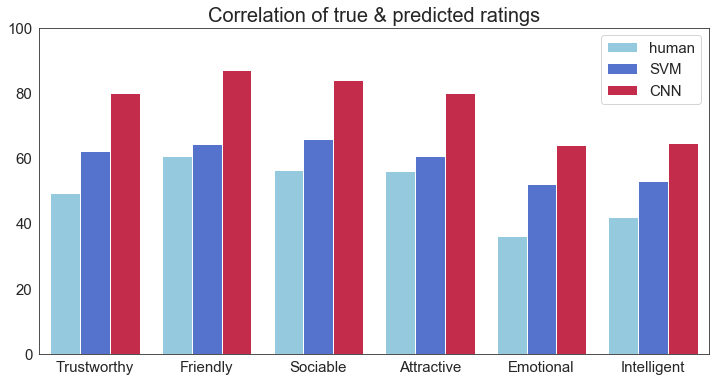

In [159]:
# make grouped barplot to summarize PC correlation of all models

#palette = sns.color_palette('viridis_r', 3)
#palette = sns.color_palette('plasma_r',3)
palette = {'human': 'skyblue', 'SVM': 'royalblue', 'CNN': 'crimson'}

fig, ax = plt.subplots(figsize=(12,6))
ax.patch.set_alpha(0.0)   # 1.0 for white axis background
fig.patch.set_alpha(0.0)

sns.barplot(x='attribute', y='PC', hue='model', data=df_PC, palette=palette)
plt.title('Correlation of true & predicted ratings', size=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(0,100)
plt.legend(fontsize=15);